<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment2/workbook-A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
# Install PyTorch Geometric
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q to·rch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-geometric

In [1]:
import numpy as np
import torch
import requests
import io
import pickle
import json

def download(url, filetype='tensor'):
    if filetype not in ['tensor', 'pickle', 'json']:
        raise ValueError('Incorrect filetype')
    response = requests.get(url)
    response.raise_for_status()
    if filetype == 'tensor':
        return torch.load(io.BytesIO(response.content))
    elif filetype == 'pickle':
        return pickle.load(io.BytesIO(response.content))
    elif filetype == 'json':
        return json.load(io.BytesIO(response.content))

# Task 1

In [2]:
## Download the dataset for image retrieval ##
data_1 = download('https://surfdrive.surf.nl/files/index.php/s/EH2tN7JiZnwdIXg/download', filetype='tensor')
data_metadata = download('https://github.com/pmernyei/wiki-cs-dataset/raw/master/dataset/metadata.json', filetype='json')

In [3]:
num_node = data_1.x.shape[0]
num_edge = data_1.edge_index.shape[1]
num_node_feature = data_1.x.shape[1]
num_class = int(max(data_1.y)+1)
num_label = sum(data_1.train_mask)

print(f'Num nodes: {num_node}')
print(f'Num edges: {num_edge}')
print()
print(f'Num node features: {num_node_feature}')
print(f'Num classes: {num_class}')
print()
print(f'Num training labels: {num_label}')

Num nodes: 10701
Num edges: 251927

Num node features: 300
Num classes: 10

Num training labels: 522


In [4]:
for i in range(num_class):
    print('{}: {}'.format(i, data_metadata['labels'][str(i)]))

0: Computational linguistics
1: Databases
2: Operating systems
3: Computer architecture
4: Computer security
5: Internet protocols
6: Computer file systems
7: Distributed computing architecture
8: Web technology
9: Programming language topics


In [5]:
def print_node(idx, url=True, label=True):
    node_info = data_metadata['nodes'][idx]
    print(f'--Node {idx}--')
    if url:
        title = node_info['title']
        wiki_url = 'https://en.wikipedia.org/wiki/' + title
        print(wiki_url)
    if label:
        print('Label:', node_info['label'])
    print()

In [6]:
for i in range(10):
    print_node(i)

--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 1--
https://en.wikipedia.org/wiki/Program_compatibility_date_range
Label: Operating systems

--Node 2--
https://en.wikipedia.org/wiki/SYSTAT_(DEC)
Label: Operating systems

--Node 3--
https://en.wikipedia.org/wiki/List_of_column-oriented_DBMSes
Label: Databases

--Node 4--
https://en.wikipedia.org/wiki/Stealth_wallpaper
Label: Computer security

--Node 5--
https://en.wikipedia.org/wiki/Scalable_TCP
Label: Internet protocols

--Node 6--
https://en.wikipedia.org/wiki/Carrier_IQ
Label: Computer security

--Node 7--
https://en.wikipedia.org/wiki/ACF2
Label: Operating systems

--Node 8--
https://en.wikipedia.org/wiki/Dorkbot_(malware)
Label: Computer security

--Node 9--
https://en.wikipedia.org/wiki/Lout_(software)
Label: Programming language topics



In [4]:
## Build the article retrieval system ##
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

In [8]:
class GraphSAGE(nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)  # the node's word vector (with size num_features) is
                                                              # transformed to a vector of size hidden_channels
        # self.conv2 = SAGEConv(hidden_channels, hidden_channels)

        self.conv3 = SAGEConv(hidden_channels, num_classes)  # we convert our nodes from hidden_channels to num_classes, the
                                                             # last update step turns a node's state into a node-class prediction

    def forward(self, x, edge_index):
        # x = (1), all nodes contain information about itself (x_size, num_features)
        x = self.conv1(x, edge_index) # x = (2), update all nodes for the first time, returning (x_size, hidden_channels)
        x = x.relu()  # activation function
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        x = F.dropout(x, p=0.5)  # attempt to combat overfitting, as we only have few labels
        x = self.conv3(x, edge_index)  # x = (3), update all nodes again, returning (x_size, num_classes)
                                       # this final update transforms each node embedding to a class prediction
                                       # we do not apply an activation, as the PyTorch CCE calculation
                                       # takes care of treating this output as 'softmax'.
        return x

    def get_embedding(self, x, edge_index, layer=3):
        if layer == 2:
            return self.forward(x, edge_index)
        elif layer == 1:
            return self.conv1(x, edge_index)

In [9]:
class GNNTrainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 epochs: int,
                 data
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
        self.data = data

    def run_trainer(self):
        losses = []
        train_accs = []
        val_accs = []
        x = self.data.x.to(self.device)
        edge_index = self.data.edge_index.to(self.device)
        y = self.data.y.to(self.device)
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            self.optimizer.zero_grad()
            out = self.model(x, edge_index)
            loss = self.criterion(out[self.data.train_mask], y[self.data.train_mask])
            loss.backward()
            self.optimizer.step()

            self.model.eval()
            pred = out.argmax(dim=1)
            train_correct = pred[self.data.train_mask] == y[self.data.train_mask]
            train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
            val_correct = pred[self.data.test_mask] == y[self.data.test_mask]
            val_acc = int(val_correct.sum()) / int(self.data.test_mask.sum())
            losses.append(loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            if epoch % 20 == 0:
                print('Epoch: {}, Loss: {}, ACC_train: {}, ACC_val: {}'.format(epoch, loss, train_acc, val_acc))
        fig, axs = plt.subplots(2, 1, figsize=(8, 10))
        t = range(1, self.epochs + 1)
        axs[0].plot(t, losses, label = 'Training Loss')
        axs[0].set_xlabel('epoch')
        axs[0].set_ylabel('loss')
        axs[0].grid(True)
        axs[0].legend()

        axs[1].plot(t, train_accs, label = 'Training Accuracy')
        axs[1].plot(t, val_accs, label = 'Validation Accuracy')
        axs[1].set_xlabel('epoch')
        axs[1].set_ylabel('accuracy')
        axs[1].grid(True)
        axs[1].legend()

        plt.show()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(hidden_channels=32, num_features=num_node_feature, num_classes=num_class).to(device=device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
trainer = GNNTrainer(model=model,
                     device=device,
                     criterion=loss_func,
                     optimizer=optimizer,
                     epochs=200,
                     data=data_1)

  2%|▎         | 5/200 [00:01<00:48,  4.02it/s]

Epoch: 0, Loss: 2.3035452365875244, ACC_train: 0.08045977011494253, ACC_val: 0.09274495138369485


 12%|█▎        | 25/200 [00:02<00:09, 18.21it/s]

Epoch: 20, Loss: 0.9961013793945312, ACC_train: 0.6839080459770115, ACC_val: 0.6320119670905011


 22%|██▏       | 43/200 [00:03<00:08, 19.45it/s]

Epoch: 40, Loss: 0.63080894947052, ACC_train: 0.7911877394636015, ACC_val: 0.7034405385190725


 32%|███▏      | 63/200 [00:04<00:07, 19.43it/s]

Epoch: 60, Loss: 0.46193963289260864, ACC_train: 0.8601532567049809, ACC_val: 0.7191473448017951


 42%|████▏     | 83/200 [00:05<00:06, 19.43it/s]

Epoch: 80, Loss: 0.33019009232521057, ACC_train: 0.9061302681992337, ACC_val: 0.7210172026925954


 52%|█████▎    | 105/200 [00:06<00:04, 19.40it/s]

Epoch: 100, Loss: 0.27641427516937256, ACC_train: 0.9195402298850575, ACC_val: 0.7284966342557966


 62%|██████▎   | 125/200 [00:07<00:03, 19.20it/s]

Epoch: 120, Loss: 0.24432139098644257, ACC_train: 0.9406130268199234, ACC_val: 0.7288706058339566


 72%|███████▎  | 145/200 [00:09<00:02, 19.30it/s]

Epoch: 140, Loss: 0.2203899770975113, ACC_train: 0.9386973180076629, ACC_val: 0.7266267763649963


 82%|████████▏ | 163/200 [00:09<00:01, 19.40it/s]

Epoch: 160, Loss: 0.1580943763256073, ACC_train: 0.9655172413793104, ACC_val: 0.7298055347793567


 92%|█████████▏| 183/200 [00:10<00:00, 19.44it/s]

Epoch: 180, Loss: 0.15395726263523102, ACC_train: 0.9674329501915708, ACC_val: 0.7275617053103964


100%|██████████| 200/200 [00:11<00:00, 16.85it/s]


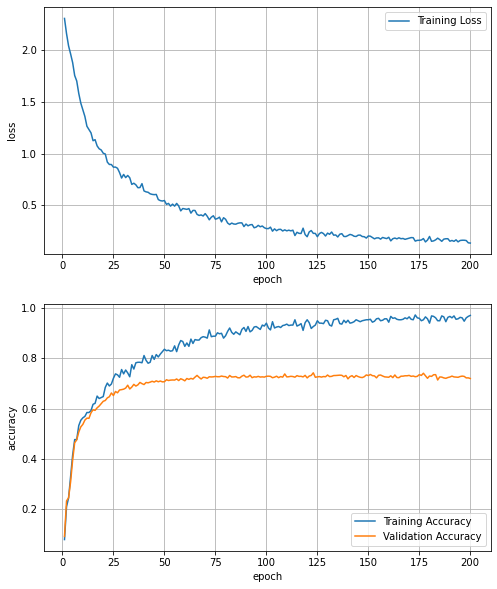

In [11]:
trainer.run_trainer()

In [12]:
embedding_1 = model.get_embedding(data_1.x.to(device), data_1.edge_index.to(device), layer=1)
embedding_2 = model.get_embedding(data_1.x.to(device), data_1.edge_index.to(device), layer=2)
# embedding_3 = model.get_embedding(data_1.x.to(device), data_1.edge_index.to(device), layer=3)

def retrieve(query, embedding, k):
    distances = []
    for i in range(num_node):
        distance = (embedding[query] - embedding[i]).pow(2).sum()
        distances.append(distance)
    return np.argsort(distances)[1:k + 1]

In [13]:
query = np.random.randint(num_node)
print_node(query)
result = retrieve(query, embedding=embedding_2, k=20)
for i in result:
    print_node(i)

--Node 3616--
https://en.wikipedia.org/wiki/Computer_security_model
Label: Computer security

--Node 7652--
https://en.wikipedia.org/wiki/Traffic_analysis
Label: Computer security

--Node 5200--
https://en.wikipedia.org/wiki/EIDAS
Label: Computer security

--Node 923--
https://en.wikipedia.org/wiki/Project_Honey_Pot
Label: Computer security

--Node 10541--
https://en.wikipedia.org/wiki/Text_Retrieval_Conference
Label: Computational linguistics

--Node 9260--
https://en.wikipedia.org/wiki/National_Privacy_Commission_(Philippines)
Label: Computer security

--Node 8537--
https://en.wikipedia.org/wiki/Four_Horsemen_of_the_Infocalypse
Label: Computer security

--Node 8667--
https://en.wikipedia.org/wiki/National_Cybersecurity_and_Communications_Integration_Center
Label: Computer security

--Node 3417--
https://en.wikipedia.org/wiki/Brewer_and_Nash_model
Label: Computer security

--Node 7491--
https://en.wikipedia.org/wiki/Hack.lu
Label: Computer security

--Node 2794--
https://en.wikipedia.

In [24]:
## Evaluate the article retrieval system ##

# Task 2

In [25]:
## Build the anomaly detection model ##

In [5]:
## Download the anomaly evaluation data ##
data_2 = download('https://surfdrive.surf.nl/files/index.php/s/EzMkh3SZbsbJb2i/download', filetype='tensor')
is_anomaly = download('https://surfdrive.surf.nl/files/index.php/s/wrK5xipcIC9DHhu/download', filetype='pickle')

In [6]:
total_node = data_2.x.shape[0]
total_edge = data_2.edge_index.shape[1]
new_node = total_node - num_node
new_edge = total_edge - num_edge
print(f'Num new nodes: {new_node}')
print(f'Num new edges: {new_edge}')

Num new nodes: 2000
Num new edges: 50176


In [7]:
print(f'Indices of new nodes are {num_node}...{total_node-1}')
print('The first 1000 are real articles, the last 1000 are anomaly articles')
print('You can use the map "is_anomaly" to identify whether a node is an anomaly or not')
e_real = num_node+500
e_anomaly = num_node+1500
print(f'E.g., is_anomaly[{e_real}] = {is_anomaly[e_real]} and is_anomaly[{e_anomaly}] = {is_anomaly[e_anomaly]}')

Indices of new nodes are 10701...12700
The first 1000 are real articles, the last 1000 are anomaly articles
You can use the map "is_anomaly" to identify whether a node is an anomaly or not
E.g., is_anomaly[11201] = 0 and is_anomaly[12201] = 1


In [8]:
# VAE model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        super(Encoder, self).__init__()
        self.device = device
        self.gnn_input = SAGEConv(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        h = torch.relu(self.gnn_input(x, edge_index))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)
        return z, mu, log_sigma

    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(self.device)
        z = mu + sigma * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.gnn_input = SAGEConv(latent_dim, hidden_dim)
        self.gnn_output = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        h = torch.relu(self.gnn_input(x, edge_index))
        x_reconstr = self.gnn_output(h, edge_index)
        return x_reconstr

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, edge_index):
        z, mu, log_sigma = self.encoder(x, edge_index)
        x_reconstr = self.decoder(z, edge_index)
        return x_reconstr, mu, log_sigma

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = num_node_feature
hidden_dim = 256
latent_dim = num_class

encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, device=device)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim)
vae = VAE(encoder=encoder, decoder=decoder).to(device)

x_normal = data_1.x.to(device)
y_normal = data_1.y.to(device)
edge_index_normal = data_1.edge_index.to(device)
x_all = data_2.x.to(device)
y_all = data_2.y.to(device)
edge_index_all = data_2.edge_index.to(device)

In [10]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

epochs = 200
print("Start training VAE...")

for epoch in range(epochs):
    vae.train()
    optimizer.zero_grad()
    x_reconstr, mu, log_sigma = vae(x_normal, edge_index_normal)
    loss, reconstr_loss, kl_loss = loss_function(x_normal, x_reconstr, mu, log_sigma)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch", epoch + 1, "Loss: ", loss.item() / num_node, "Reconstruction Loss:", reconstr_loss.item() / num_node, "KL Loss:", kl_loss.item() / num_node)
print("Training complete!")

Start training VAE...
Epoch 1 Loss:  31.20967958602 Reconstruction Loss: 31.1414178581441 KL Loss: 0.0682607354343344
Epoch 21 Loss:  3.724197796934866 Reconstruction Loss: 3.3656820916269505 KL Loss: 0.3585157509374124
Epoch 41 Loss:  2.7458710780534528 Reconstruction Loss: 2.5655170223577235 KL Loss: 0.18035399865885782
Epoch 61 Loss:  2.3411162654191195 Reconstruction Loss: 2.250058405756471 KL Loss: 0.0910579166995199
Epoch 81 Loss:  2.057493349044482 Reconstruction Loss: 1.99906696804037 KL Loss: 0.0584264152262347
Epoch 101 Loss:  1.8619468609826184 Reconstruction Loss: 1.7854968285674235 KL Loss: 0.07645000389675906
Epoch 121 Loss:  1.745343418547332 Reconstruction Loss: 1.6507145944304271 KL Loss: 0.09462882411690496
Epoch 141 Loss:  1.6740352829174843 Reconstruction Loss: 1.5696932164634145 KL Loss: 0.10434204363932109
Epoch 161 Loss:  1.6258678730375666 Reconstruction Loss: 1.5080075204712176 KL Loss: 0.11786035256634894
Epoch 181 Loss:  1.5887331280370993 Reconstruction Loss

In [11]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = input_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

In [14]:
elbos_normal = []
elbos_anomaly = []
with torch.no_grad():
    x_reconstr, mu, log_sigma = vae(x_normal, edge_index_normal)
    elbo, _, _ = elbo_elementwise(x_normal, x_reconstr, mu, log_sigma)
    elbos_normal.append(elbo.cpu().numpy())

    x_reconstr, mu, log_sigma = vae(x_all, edge_index_all)
    elbo, _, _ = elbo_elementwise(x_all[-1000:], x_reconstr[-1000:], mu[-1000:], log_sigma[-1000:])
    elbos_anomaly.append(elbo.cpu().numpy())

elbos_normal = np.concatenate(elbos_normal)  # loss values represent *negative* ELBO values
elbos_anomaly = np.concatenate(elbos_anomaly)

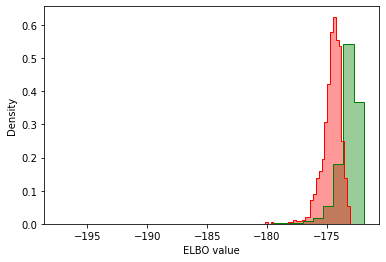

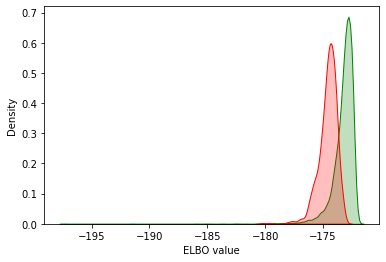

In [15]:
import seaborn as sns

def density_histogram(neg, pos, bins=30, alpha=0.4):
    plt.figure()
    plt.hist(neg, bins=bins, density=True, histtype="bar", color="g", alpha=alpha)
    plt.hist(neg, bins=bins, density=True, histtype="step", color="g", alpha=1)
    plt.hist(pos, bins=bins, density=True, histtype="bar", color="r", alpha=alpha)
    plt.hist(pos, bins=bins, density=True, histtype="step", color="r", alpha=1)
    plt.xlabel("ELBO value")
    plt.ylabel("Density")
    plt.show()

def density_plot(neg, pos):
    plt.figure()
    sns.kdeplot(neg, shade=True, color="g")
    sns.kdeplot(pos, shade=True, color="r")
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

density_histogram(elbos_normal, elbos_anomaly)
density_plot(elbos_normal, elbos_anomaly)

In [29]:
## Evaluate the anomaly detection model ##